## 12. Дифференциальные уравнения. Робин Гуд
Робин Гуд бросает камень с привязанным к нему письмом
через бойницу крепостной стены в открытое окно, стоящего за ней замка:
``` 
                    стена                    замок
                    _____ 
                   [     ]                  ______ 
                   [     ]                 [      ]
                   [_____]                 [      ]
                   бойница                 [      ]
                    _____                  [      ]
                   [     ]                 [      ]
                   [     ]                   окно ]
                   [     ]                 [      ]
                   [     ]                 [      ]
.                  [     ]                 [      ]
 \0 _              [     ]                 [      ]
  I                [     ]                 [      ]
 / \               [     ]                 [      ]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
```

Смоделируйте полет камня с помощью функции `integrate.solve_ivp`.
Рассмотрите следующие события (events): 
   1. камень упал на землю, не долетев до окна (либо до, либо после стены);
   2. камень не попал в бойницу (ударился о стену);
   3. камень застрял в бойнице (стукнулся о «пол» или «потолок» бойницы и упал внутри нее); 
   4. камень стукнулся о  стену замка (не попав в окно);
   5. камень попал в окно 
      (для простоты считаем, что и крепостная стена, и замок очень высокие
      и сверху через них камень перебросить нельзя).
При наступлении каждого из этих событий дальнейшее интегрирование прекращаются. 

Написать функцию, на вход которой подаются:
  * параметры:
    масса камня,
    расстояние от Робин Гуда до стены,
    толщину стены (равную длине бойницы),
    расстояние от земли до бойницы и высоту бойницы,
    расстояние от стены до замка,
    расстояние от земли до окна и высоту окна,

  * начальные условия:
    угол броска и начальную скорость камня.

Программа должна отображать «вид сбоку» (многоугольники можно нарисовать с помощью функций
`matplotlib.patches.Patch`) и траекторию полета.

Импортирование библиотек:

In [ ]:
from scipy import integrate 
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt

Запрос на ввод параметров задачи (вместо введения всех параметров каждый раз можно использовать список testinputs):

In [ ]:
print("Enter: 1)Initial velocity 2)Throwing angle 3)Distance between RH and the wall 4)Wall thickness 5)Distance between ground level and the embrasure 6)Embrasure height 7)Distance between the wall and the castle 8)Distance between ground level and the window 9)Window height")
#testinputs = [35,60,30,10,36,10,20,40,10]
#inputs=testinputs
inputs = [int(x) for x in input().split()]

Enter: 1)Initial velocity 2)Throwing angle 3)Distance between RH and the wall 4)Wall thickness 5)Distance between ground level and the embrasure 6)Embrasure height 7)Distance between the wall and the castle 8)Distance between ground level and the window 9)Window height


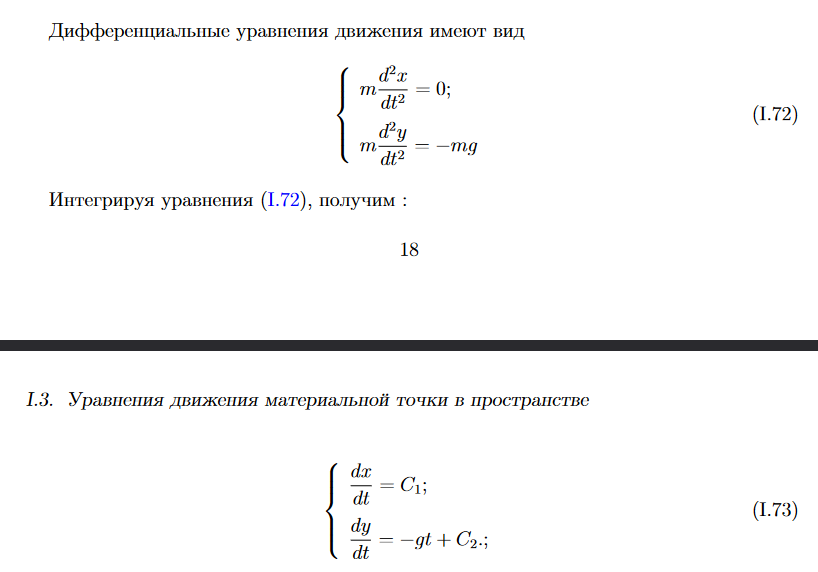

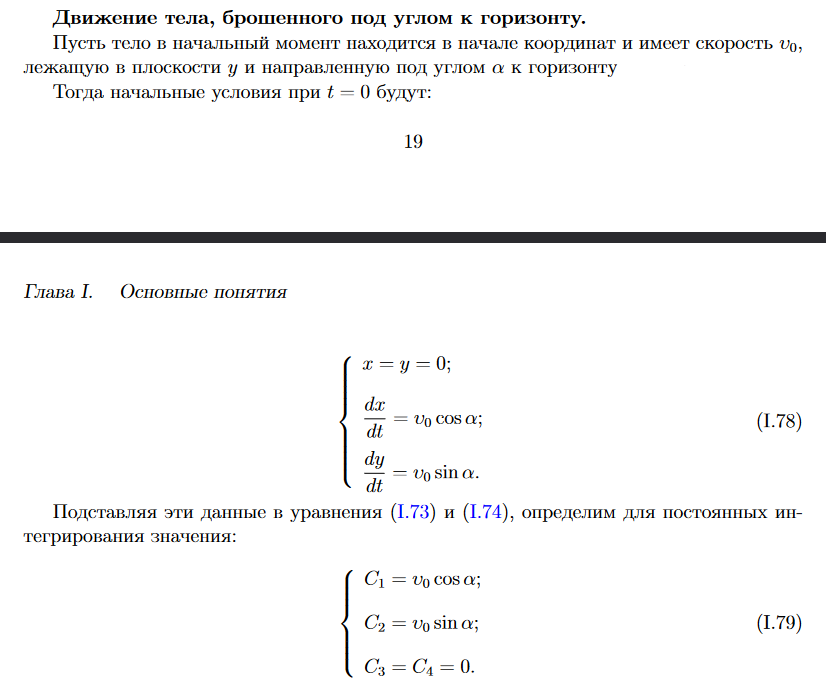

Для определения системы дифференциальных уравнений, чтобы впоследствии предоставить её решателю, я воспользовался следующим примером:

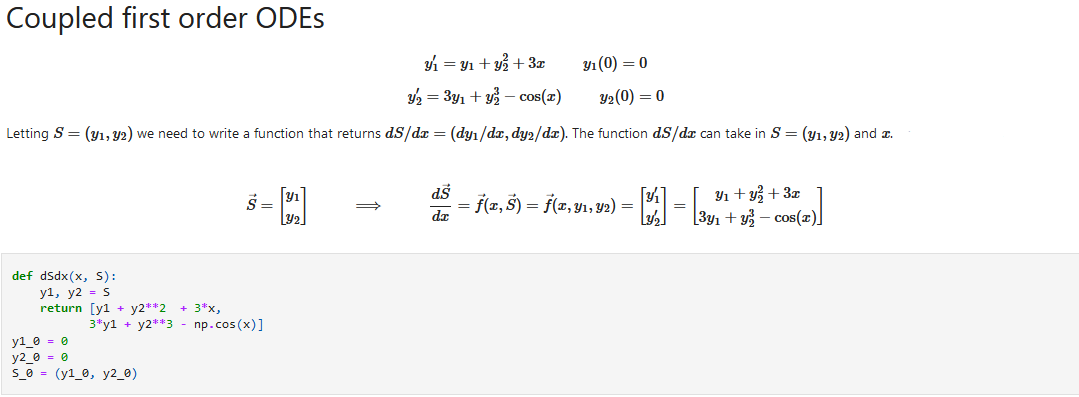

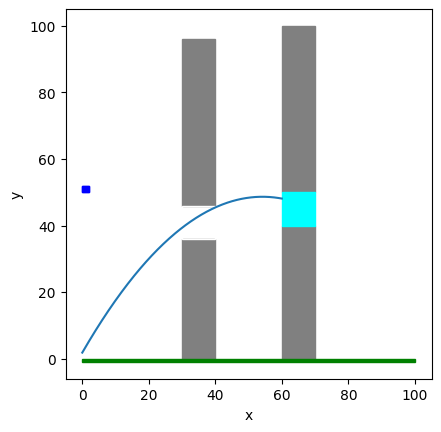

In [ ]:
def dSdt(t,S):
  x,y=S
  v0=inputs[0]
  alpha=(inputs[1]*3.14)/180
  g=9.8
  return [v0*np.cos(alpha),
          v0*np.sin(alpha)-g*t]
x_0=0
y_0=1.8 #Начальные условия - координаты камня при t=0, допустим, что Робин Гуд держит камень на высоте 1.8м
S_0=(x_0,y_0)

def event_hit_wall(t,S):
  x,y=S
  if int(x)==inputs[2] and( int(y)<inputs[4] or int(y)>inputs[4]+inputs[5]): #Камень находится на левой границе стены и не на высоте бойницы, т.е. ударился об стену
    cyansign = Rectangle((0,50),2,2,color="cyan")
    plt.gca().add_patch(cyansign)
    return 0
  return 1

def event_hit_embrasure(t,S):
  x,y=S
  if inputs[2]<int(x)<inputs[2]+inputs[3] and (int(y)<=inputs[4] or int(y)>=inputs[4]+inputs[5]): #Камень находится внутри стены по абсциссе и касается верхней или нижней границы бойницы
    redsign = Rectangle ((0,50),2,2,color="red")
    plt.gca().add_patch(redsign)
    return 0
  return 1
def event_hit_nothing(t,S):
  x,y=S
  if t>1 and int(y)==0: #Камень спустя некоторое время упал на землю
    greensign = Rectangle ((0,50),2,2,color="green")
    plt.gca().add_patch(greensign)
    return 0
  return 1
def event_hit_window(t,S):
  x,y=S
  if int(x)==inputs[2]+inputs[3]+inputs[6] and (inputs[7]<int(y)<inputs[7]+inputs[8]): #Камень находится на левой границе замка и на высоте окна, т.е. ударился в окно
    bluesign = Rectangle ((0,50),2,2,color="blue")
    plt.gca().add_patch(bluesign)
    return 0
  return 1
def event_hit_castle(t,S):
  x,y=S
  if int(x)==(inputs[2]+inputs[3]+inputs[6]) and (int(y)>=inputs[7]+inputs[8] or int(y)<=inputs[7]): #Камень находится на левой границе замка и не на высоте окна, т.е. ударился об стену замка
    orangesign = Rectangle ((0,50),2,2,color="orange")
    plt.gca().add_patch(orangesign)
    return 0
  return 1
#Для всех событий свойство terminal должно быть равно True, чтобы интегрирование прекращалось 
event_hit_wall.terminal = True
event_hit_embrasure.terminal= True
event_hit_nothing.terminal=True
event_hit_window.terminal=True
event_hit_castle.terminal=True
#Объединяем события в список, чтобы не занимать много места внутри скобок решателя
funcevents=[event_hit_wall,
            event_hit_embrasure,
            event_hit_window,
            event_hit_castle,
            event_hit_nothing]
t=np.linspace(0,10,1000) #Предположим, что камень будет лететь не более 10 секунд, тогда решим 1000 раз от 0 до 10
sol=integrate.solve_ivp(dSdt,(0,10),y0=S_0,t_eval=t,events=funcevents,max_step=0.0001) #dSdt - функция, (0,10) - область интегрирования, y0 - начальные условия, t_eval - хранение решений, events - события, max_step - шаг решателя, если он слишком велик, то могут пропуститься события
x,y=sol.y

#Создаем фигуры стены с бойницей и башни замка с окном
grass = Rectangle ((0,-1),100,1,color="green")
lowerwall = Rectangle((inputs[2],0),inputs[3],inputs[4],color="grey")
upperwall = Rectangle ((inputs[2],inputs[4]+inputs[5]),inputs[3],50,color="grey")
embrasure = Rectangle((inputs[2],inputs[4]),inputs[3],inputs[5],fill=False,edgecolor="white")
lowertower = Rectangle ((inputs[2]+inputs[3]+inputs[6],0),inputs[3],inputs[7],color="grey")
uppertower = Rectangle ((inputs[2]+inputs[3]+inputs[6],inputs[7]+inputs[8]),inputs[3],50,color="grey")
window = Rectangle((inputs[2]+inputs[3]+inputs[6],inputs[7]),inputs[3],inputs[8],color="aqua")
plt.gca().add_patch(lowerwall)
plt.gca().add_patch(upperwall)
plt.gca().add_patch(lowertower)
plt.gca().add_patch(uppertower)
plt.gca().add_patch(window)
plt.gca().add_patch(embrasure)
plt.gca().add_patch(grass)
plt.plot(x,y)
plt.axis("scaled")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Таким образом, строится график полета камня с заданными условиями, при этом если случается какое-либо из событий, то график прерывается. Для более точного понимания, какое именно событие прервало процесс интегрирования, также отрисовывается небольшой цветной квадрат. Примеры различных введенных данных, при которых происходят различные события:

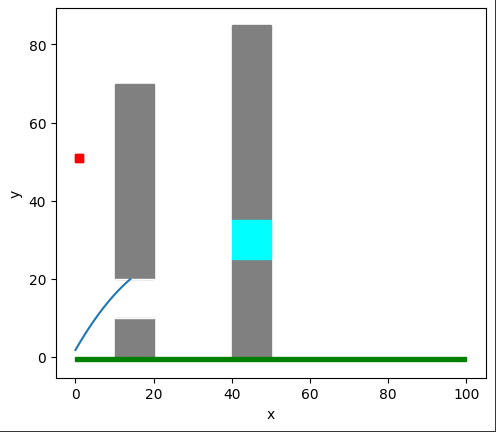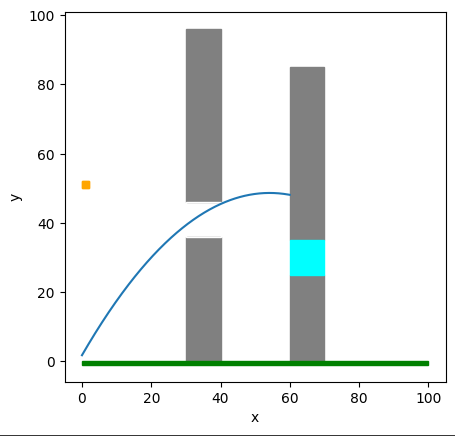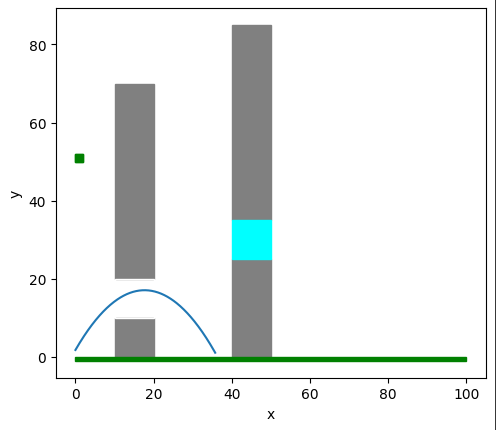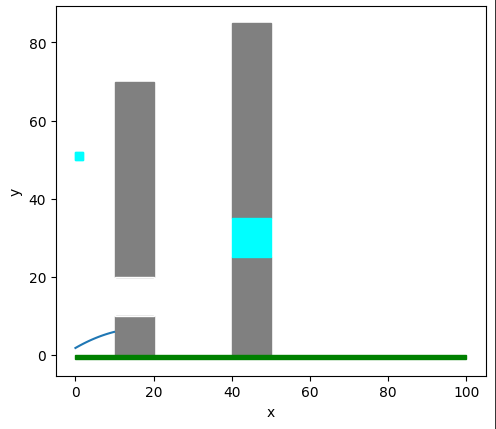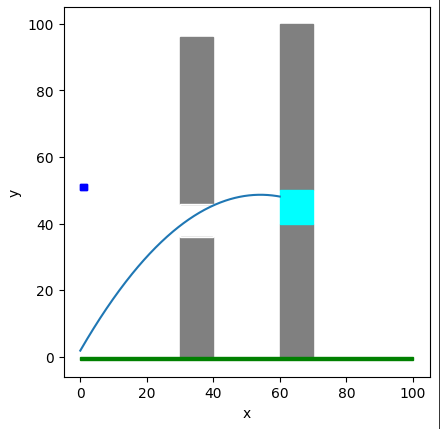